In [1]:
import sys
sys.path.extend(['../', '../read_utils/'])

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

from scipy.interpolate import griddata
from scipy.interpolate import interp1d

from io_f import read_data_file

In [2]:
root = "../data/indoor-location-navigation"

trainTrajFiles = glob(f"{root}/train/*/*")
metaFiles = glob(f"{root}/metadata/*/*")
metaRoot = f"{root}/metadata/"

trainDF = pd.DataFrame({"TrajFolders": trainTrajFiles})
trainDF["ID"] = trainDF["TrajFolders"].apply(lambda x: x.split("/")[-2])
trainDF["floor"] = trainDF["TrajFolders"].apply(lambda x: x.split("/")[-1])
trainDF["subFiles"] = trainDF["TrajFolders"].apply(lambda x: glob(x+"/*.txt"))
trainDF["floorImage"] = trainDF[["ID", "floor"]].apply(lambda x: metaRoot + f"/{x.ID}/{x.floor}/floor_image.png", axis=1)
trainDF["floorInfo"] = trainDF[["ID", "floor"]].apply(lambda x: metaRoot + f"/{x.ID}/{x.floor}/floor_info.json", axis=1)
trainDF["floorGeoJson"] = trainDF[["ID", "floor"]].apply(lambda x: metaRoot + f"/{x.ID}/{x.floor}/geojson_map.json", axis=1)
print(trainDF.shape)
print(trainDF["ID"].nunique())

trainDF.sort_values(by=["ID","floor"], inplace=True)
trainDF.reset_index(drop=True, inplace=True)
trainDF.head()

(981, 7)
204


,TrajFolders,ID,floor,subFiles,floorImage,floorInfo,floorGeoJson
0,../data/indoor-location-navigation/train/5a054...,5a0546857ecc773753327266,B1,[../data/indoor-location-navigation/train/5a05...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...
1,../data/indoor-location-navigation/train/5a054...,5a0546857ecc773753327266,F1,[../data/indoor-location-navigation/train/5a05...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...
2,../data/indoor-location-navigation/train/5a054...,5a0546857ecc773753327266,F2,[../data/indoor-location-navigation/train/5a05...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...
3,../data/indoor-location-navigation/train/5a054...,5a0546857ecc773753327266,F3,[../data/indoor-location-navigation/train/5a05...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...
4,../data/indoor-location-navigation/train/5a054...,5a0546857ecc773753327266,F4,[../data/indoor-location-navigation/train/5a05...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...,../data/indoor-location-navigation/metadata//5...


In [3]:
# path_filename = trainDF["subFiles"].values[0][0]

# path_datas = read_data_file(path_filename)
# acce_datas = path_datas.acce
# magn_datas = path_datas.magn
# ahrs_datas = path_datas.ahrs
# wifi_datas = path_datas.wifi
# ibeacon_datas = path_datas.ibeacon
# posi_datas = path_datas.waypoint

# step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
# step_positions2 = csp(acce_datas, ahrs_datas, posi_datas)

In [4]:
# waypoints = []
paths = trainDF["subFiles"].values[0]
allSensors = []
for path in paths:
    path_datas = read_data_file(path)
    allSensors.append(path_datas)
    # acce_datas = path_datas.acce
    # magn_datas = path_datas.magn
    # ahrs_datas = path_datas.ahrs
    # wifi_datas = path_datas.wifi
    # ibeacon_datas = path_datas.ibeacon
    # posi_datas = path_datas.waypoint
    # waypoints.append(posi_datas)

In [5]:
wp = np.concatenate([x.waypoint for x in allSensors])
mags = np.concatenate([x.magn for x in allSensors])
iBeac = np.concatenate([x.ibeacon for x in allSensors])
wifiCat = np.concatenate([x.wifi for x in allSensors])

print(wp.shape, mags.shape, iBeac.shape, wifiCat.shape)

(525, 3) (194071, 4) (31834, 3) (327973, 5)


In [6]:
print(wp[0])
print(mags[0])
print(iBeac[0])
print(wifiCat[0])

[1.57846455e+12 1.78333470e+02 1.71011760e+02]
[ 1.57846455e+12 -3.36273200e+01 -9.30023200e+00 -2.12997440e+01]
['1578464553229'
 'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c'
 '-85']
['1578464553216' '02f6962ba3377969370d83878c6b096b29be9e31'
 'f5167a15da108bf5a758d1a6fe1c144b8f168688' '-42' '1578464551918']


In [47]:
print(np.unique(wp[:, 0]).shape)

(525,)


In [20]:
# Magnetic field 
magVal = np.linalg.norm(mags[:, 1:], axis=1)  # shape is (194071),)

interp = interp1d(wp[:, 0], wp[:, 1:], axis=0, fill_value="extrapolate", kind="linear")
magnPos = interp(mags[:, 0])  # shape is (194071),)

In [46]:
print(np.unique(mags[:, 0]).shape)
print('')
print(mags[0])
print(mags[:, 1:][0], magVal[0])
print(magnPos[0], mags[:, 0][0])

(194071,)

[ 1.57846455e+12 -3.36273200e+01 -9.30023200e+00 -2.12997440e+01]
[-33.62732   -9.300232 -21.299744] 40.87750065869683
[178.40783982 171.00720927] 1578464553140.0


In [22]:
# Wifi
wifiBSSID = np.unique(wifiCat[:, 2])[3]  # 00c8933965e23cd2bb890ca08ee7f8a22f933df8
f = wifiCat[:,2]==wifiBSSID

wifiSignal = wifiCat[f][:, [0, 3]].astype(np.float32)  # shape is (380, 2)

interp = interp1d(wp[:, 0], wp[:, 1:], axis=0, fill_value="extrapolate")
wifiPos = interp(wifiSignal[:, 0])  # shape is (380, 2)

In [45]:
print(np.unique(wifiSignal[:, 0]).shape)
print('')
print(wifiCat[f][0])
print(wifiSignal[0])
print(wifiPos[0], wifiSignal[:, 0][0])

(16,)

['1578468210104' '506a2ed42a391ab1c3e09b9674cdb59088d9c45b'
 '00c8933965e23cd2bb890ca08ee7f8a22f933df8' '-76' '1578468208995']
[ 1.5784682e+12 -7.6000000e+01]
[110.77077453 148.24446635] 1578468200000.0


In [24]:
# iBeacon
beacID = np.unique(iBeac[:, 1])[2]  # 4e9d3569a79dcbd102831d1bd587aa4e868ae797_20a3404e313632fda2f7d36e5e61f744a260ac4f_acc3938f2906d73cf4d4a2ac30077892bf572304

beacData = iBeac[iBeac[:, 1]==beacID][:, [0, 2]].astype(np.float32)  # shape is (93, 2)

interp = interp1d(wp[:, 0], wp[:, 1:], axis=0, fill_value="extrapolate")
beacPos = interp(beacData[:, 0])  # shape is (93, 2)

In [44]:
print(np.unique(beacData[:, 0]).shape)
print('')
print(iBeac[iBeac[:, 1]==beacID][0])
print(beacData[0])
print(beacPos[0], beacData[:, 0][0])


(15,)

['1578468212262'
 '4e9d3569a79dcbd102831d1bd587aa4e868ae797_20a3404e313632fda2f7d36e5e61f744a260ac4f_acc3938f2906d73cf4d4a2ac30077892bf572304'
 '-98']
[ 1.5784682e+12 -9.8000000e+01]
[110.77077453 148.24446635] 1578468200000.0


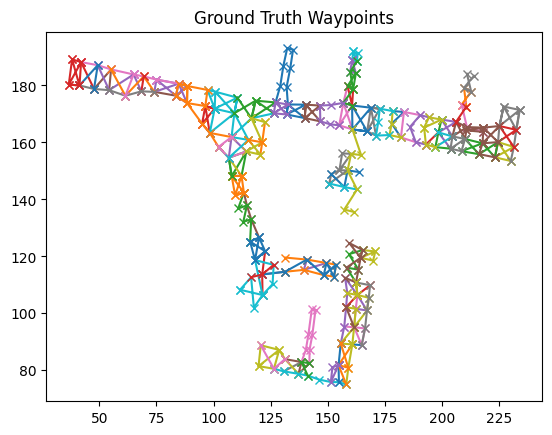

In [26]:
for s in allSensors:
    w = s.waypoint
    plt.plot(w[:, 1], w[:, 2], "x-")
plt.title("Ground Truth Waypoints")
plt.show()

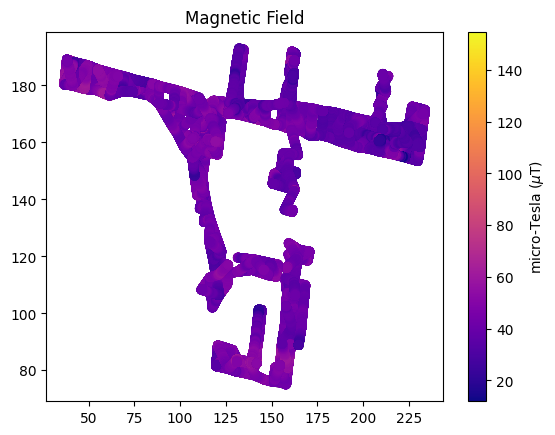

In [27]:
sc = plt.scatter(magnPos[:, 0], magnPos[:, 1], c=magVal, cmap="plasma")
plt.colorbar(sc, label="micro-Tesla ($\mu$T)")
plt.title("Magnetic Field")
plt.show()

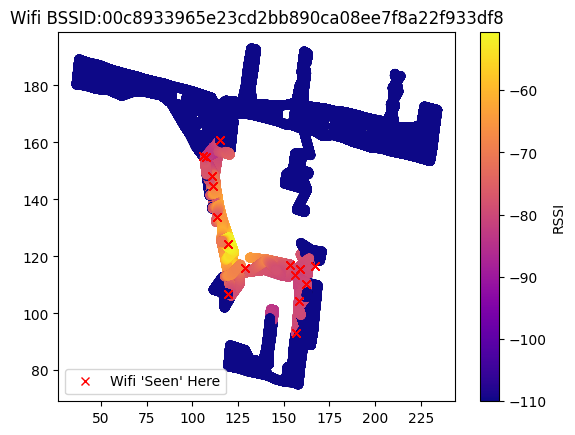

In [55]:
wifiInterpVal = griddata(
    wifiPos[:, 0:2],
    wifiSignal[:, 1],
    magnPos,
    fill_value=-110,
    #fill_value=wifiSignal[:, 1].min(),
    method="cubic",
)
sc = plt.scatter(magnPos[:, 0], magnPos[:, 1], c=wifiInterpVal, cmap="plasma")
plt.colorbar(sc, label="RSSI")
plt.plot(wifiPos[:, 0], wifiPos[:, 1], 'xr', label="Wifi 'Seen' Here")
plt.title(f"Wifi BSSID:{wifiBSSID}")
plt.legend()
plt.show()

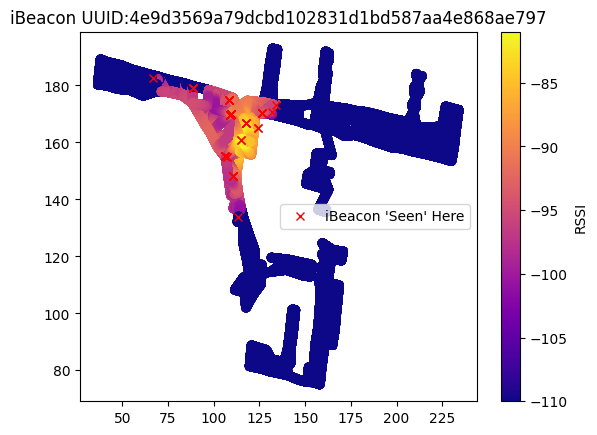

In [58]:
beacInterpVal = griddata(
    beacPos[:, 0:2],
    beacData[:, 1],
    magnPos, 
    fill_value=-110,
    #fill_value=beacData[:, 1].min(),
    method="cubic",
)
sc = plt.scatter(magnPos[:, 0], magnPos[:, 1], c=beacInterpVal, cmap="plasma")
plt.colorbar(sc, label="RSSI")
plt.plot(beacPos[:, 0], beacPos[:, 1], 'xr', label="iBeacon 'Seen' Here")
bUUID = beacID.split("_")[0]
plt.title(f"iBeacon UUID:{bUUID}")
plt.legend()
plt.show()